# Redes Neurais Convolucionais (CNN)


`Redes Neurais Convolucionais` podem ser utilizadas para descobrir padrões contidos em uma imagem. 

Tradicionalmente uma `CNN` é composta por um conjunto de camadas de `Convolução + Ativação + Pooling`, seguida de uma `Camada Completamente Conectada` que funciona como uma função de distribuição de probabilidades.


As CNN são bastante utilizadas em 2 tipos de problemas:
- Classificação de imagens
- Segmentação de imagens

<img src='images/cnn_padrao.png' />


### Exemplificando o `Filtro Convolucional`: 
<img src='images/conv-full-layer.gif'/>

### Exemplificando a `Função de Ativação ReLU`: 
<img src='images/relu.jpeg'/>

### Exemplificando o `Filtro Max Pooling`:
<img src='images/maxpool_animation.gif'/>

### Exemplificando a classificação de uma imagem:
<img src='images/cnn.gif'/>


- https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1
- https://www.guru99.com/convnet-tensorflow-image-classification.html
- https://medium.com/x8-the-ai-community/cnn-9c5e63703c3f
- https://compsci682.github.io/notes/convolutional-networks/
 
- http://setosa.io/ev/image-kernels/
- https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1


# Algumas redes famosas

- [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) - A primeira aplicação bem sucessida de uma CNN foi desenvolvida por Yann LeCun em 1998.

- [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) - Esse foi o primeiro trabalho que popularizou a utilização de CNN na área de visão computacional.

- [VGGNet](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) - 

- [ResNet](https://arxiv.org/pdf/1512.03385.pdf) - 

- [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) - 

# Temas de otimização

- Data Augmentation
- Transfer Learning
- Visualizing what ConvNets learn

# Definindo o modelo CNN 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
  
# Definindo a CNN
class Net(nn.Module):
    
    def __init__(self, weight=0):
        super(Net, self).__init__()
        
        # Define as camadas mas nao define a forma como elas devem ser conectadas ainda
        # Camada convolucional: https://pytorch.org/docs/stable/nn.html#conv2d
        # Camada de max pooling: https://pytorch.org/docs/stable/nn.html#maxpool2d
        
        # 512 x 512 x 3 -> 510 x 510 x 16
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0, bias=False)
        # 255 x 255 x 16 -> 253 x 253 x 32
        self.conv2 = nn.Conv2d(16, 32, 3)
        # 126 x 126 x 32 -> 124 x 124 x 64
        self.conv3 = nn.Conv2d(32, 64, 3)
        # 62 x 62 x 64 -> 60 x 60 x 96
        self.conv4 = nn.Conv2d(64, 96, 3) 
        
        # 60 * 60 * 96 -> 30 * 30 * 96
        self.pool = nn.MaxPool2d(2, 2)
        
        # 30 * 30 * 96 -> 5000
        self.fc1 = nn.Linear(30*30*96, 5000)
        # 5000 -> 500
        self.fc2 = nn.Linear(5000, 500)
        # 500 -> 3
        self.fc3 = nn.Linear(500, 3)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
                
        # Define a forma como as camadas do modelo devem ser conectadas
        
        #print("input --> ", x.size())
        
        # aplica a convolucao e a ReLU
        x = F.relu(self.conv1(x))
        # aplica a funcao pooling na saida da ReLU
        x = self.pool(x)
        
        # aplica a convolucao e a ReLU
        x = F.relu(self.conv2(x))
        # aplica a funcao pooling na saida da ReLU
        x = self.pool(x)
        
        # aplica a convolucao e a ReLU
        x = F.relu(self.conv3(x))
        # aplica a funcao pooling na saida da ReLU
        x = self.pool(x)
        
        # aplica a convolucao e a ReLU
        x = F.relu(self.conv4(x))
        # aplica a funcao pooling na saida da ReLU
        x = self.pool(x)
        #print("pool4 --> ", x.size())
                
        # flattern
        x = x.view(-1, 30*30*96)
        
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add 3 hidden layer
        x = self.fc3(x)
        
        return x;
        
        # retorna todas as saidas separadamente
        # return torch.squeeze(self.conv1.weight).detach().numpy(), conv_x, activated_x, pooled_x, x
    
# instancia o modelo criado
model = Net()
# mostra as camadas do modelo criado
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=86400, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=3, bias=True)
  (dropout): Dropout(p=0.25)
)


# Definindo a função de perda e a taxa de aprendizado

In [3]:
import torch.optim as optim

# specify the loss function (categorical cross-entropy) for optimization
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Definindo o dataset

In [4]:
import os, os.path, random
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# All images are resized to 512 x 512 and normalized
# Only training images receive further augmentation
dataset_transforms = {
    'all': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'train': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normaliza os pixels para 0..1
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),    
}

dataset_dir = "datasets/animais"
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_dir, x), dataset_transforms[x]) for x in ['train', 'test', 'all']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20, shuffle=False, num_workers=4) for x in ['train', 'test', 'all']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'all']}

class_names = image_datasets['train'].classes
n_classes = len(class_names)

print(f"Qtd de total de imagens: {dataset_sizes['all']}")
print(f"Qtd de imagens de treinamento: {dataset_sizes['train']}")
print(f"Qtd de imagens de teste: {dataset_sizes['test']}")
print(f"Classes: {class_names}")

Qtd de total de imagens: 45
Qtd de imagens de treinamento: 39
Qtd de imagens de teste: 6
Classes: ['gato', 'pedrita', 'peixe']


# Exibe o dataset

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

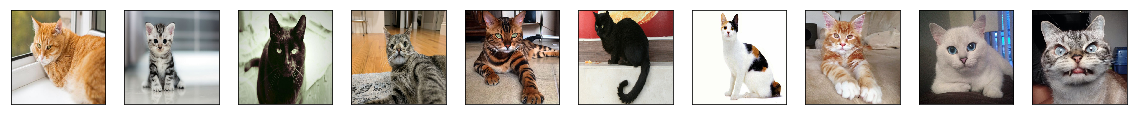

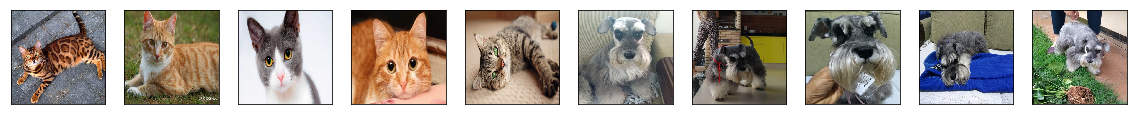

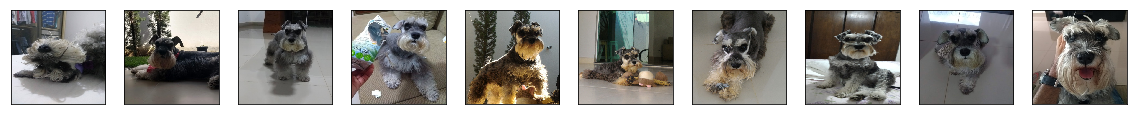

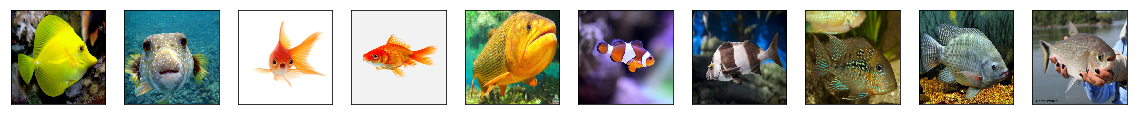

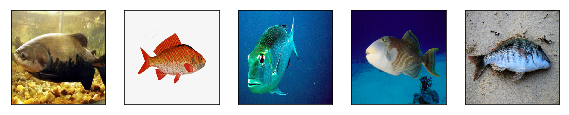

In [6]:
def show_dataset_batch(data, target, last_row=0):
    images = data.numpy()     
    for idx in np.arange(len(images)):
        img = images[idx] / 2 + 0.5
        row = int(np.floor(idx/10)) +last_row        
        if (idx % 10 == 0):
            fig = plt.figure(figsize=(20, 20))

        ax = fig.add_subplot(1, 10, (idx-10+1) if idx >= 10 else idx +1, xticks=[], yticks=[])
        ax.imshow(np.transpose(img, (1, 2, 0)))

    last_row += int(np.floor(len(images)/10))
    
    
def show_dataset(dataloader):
    
    rows = int(np.ceil(dataset_sizes['all']/10.0))
    cols = 10

    for data, target in dataloader:
        show_dataset_batch(data, target)
        
show_dataset(dataloaders['all'])

# Treinando a rede

In [ ]:
import time

# numero de epocas para treinar o modelo
n_epochs = 2
train_loss_min = np.Inf


since = time.time()
for epoch in range(1, n_epochs+1):

    print("")
    print('Epoch {}/{}'.format(epoch, n_epochs))
    print('-' * 10)
        
    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_i, (data, target) in enumerate(dataloaders['train']):
        
        print(f"Processando {batch_i+1}º lote com {len(data)} imagens...")
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update for all the weights of the network)
        optimizer.step()
        
        # update training loss 
        train_loss += loss.item()
    
    # calculate average loss
    train_loss = train_loss/len(dataloaders['train'].dataset)
    
    # estatisticas de treinamento
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    # salva o melhor modelo
    if train_loss <= train_loss_min:
        print('Train loss diminuiu ({:.6f} --> {:.6f}). Salvando modelo ...'.format(train_loss_min, train_loss))
        torch.save(model.state_dict(), 'model.pt')
        train_loss_min = train_loss

time_elapsed = time.time() - since
print('Treinamento realizado em {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


Epoch 1/2
----------
Processando 1º lote com 20 imagens...


In [14]:
# carrega o modelo de melhor resultado no treinamento
model.load_state_dict(torch.load('model.pt'))

# Verificando a acurácia da rede treinada

In [7]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in dataloaders['test']:
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    
    # calculate the batch loss
    loss = criterion(output, target)
    
    # update test loss 
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(dataloaders['test'].dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(0, n_classes):
    if class_total[i] > 0:
        print('Acurácia para a classe %5s: %2d%% (%2d/%2d)' % (class_names[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Acurácia para a classe %5s: N/A (no training examples)' % (class_names[i]))

print('Acurácia geral média: %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.099712

Acurácia para a classe  gato:  0% ( 0/ 2)
Acurácia para a classe pedrita: 100% ( 2/ 2)
Acurácia para a classe peixe:  0% ( 0/ 2)
Acurácia geral média: 33% ( 2/ 6)


/home/dalifreire/anaconda3/envs/cnn_hello_world/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# Exibindo resultados para as imagens de teste

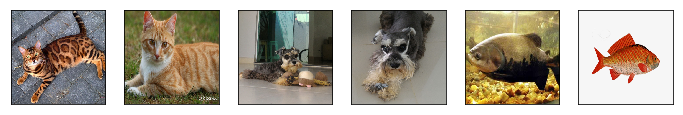

In [12]:
# exibe as imagens do dataset de test
show_dataset(dataloaders['test'])

Pred. [0 0 0 0 0 0]
Label [0 0 1 1 2 2]


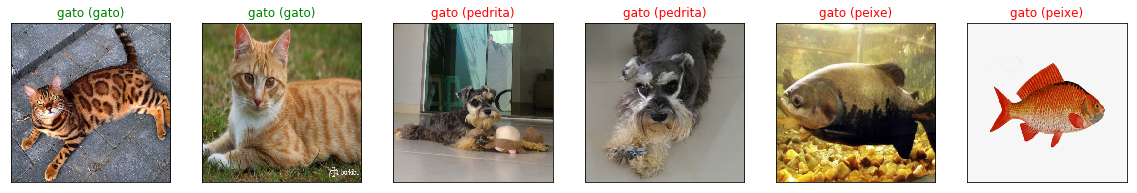

Process Process-28:
Process Process-27:
Process Process-26:
Process Process-25:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dalifreire/anaconda3/envs/cnn_hello_world/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dalifreire/anaconda3/envs/cnn_hello_world/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dalifreire/anaconda3/envs/cnn_hello_world/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dalifreire/anaconda3/envs/cnn_hello_world/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dalifreire/anaconda3/envs/cnn_hello_world/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/dalifreire/anaconda3/envs/cnn_

In [13]:
# obtain one batch of test images
dataiter = iter(dataloaders['test'])
data, target = dataiter.next()
images = data.numpy()

# get sample outputs
output = model(data)

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())
print(f"Pred. {preds}")
print(f"Label {target.numpy()}")

fig = plt.figure(figsize=(20, 20))
for idx in np.arange(len(images)):
    img = images[idx] / 2 + 0.5
    ax = fig.add_subplot(1, len(images), idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[target[idx]]), 
                 color=('g' if preds[idx]==target[idx].item() else 'r'))

# Aumentando as imagens da base

In [6]:
# All images are resized to 512 x 512 and normalized
# Only training images receive further augmentation
dataset_transforms = {
    'all': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'train': transforms.Compose([
        transforms.RandomResizedCrop(512),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(1.0, 1.1), shear=5, resample=False, fillcolor=0),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normaliza os pixels para 0..1
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),    
}

dataset_dir = "datasets/animais"
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_dir, x), dataset_transforms[x]) for x in ['train', 'test', 'all']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20, shuffle=False, num_workers=4) for x in ['train', 'test', 'all']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'all']}

class_names = image_datasets['train'].classes
n_classes = len(class_names)

print(f"Qtd de total de imagens: {dataset_sizes['all']}")
print(f"Qtd de imagens de treinamento: {dataset_sizes['train']}")
print(f"Qtd de imagens de teste: {dataset_sizes['test']}")
print(f"Classes: {class_names}")

Qtd de total de imagens: 24
Qtd de imagens de treinamento: 20
Qtd de imagens de teste: 4
Classes: ['gato', 'pedrita']


#### Imagens aumentadas

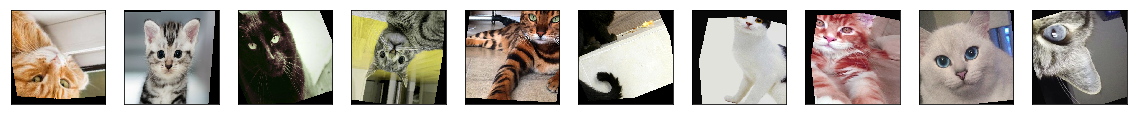

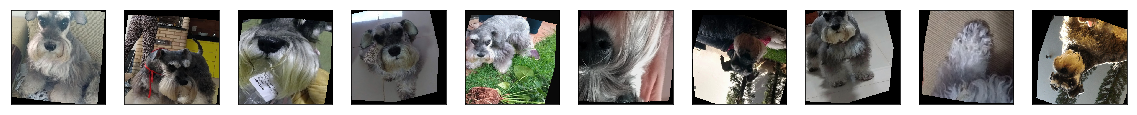

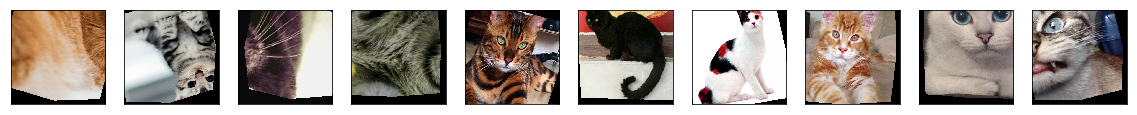

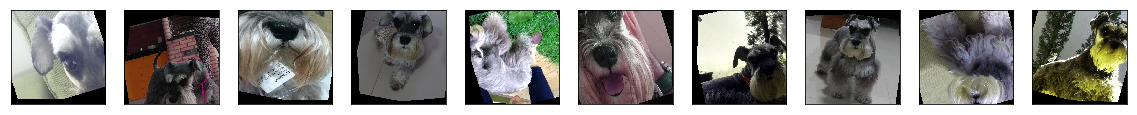

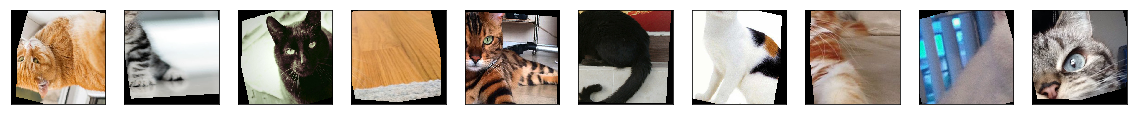

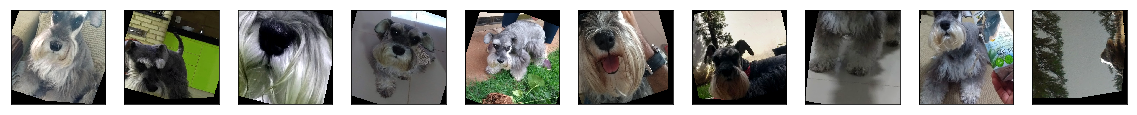

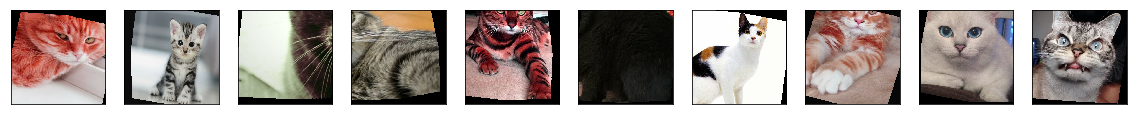

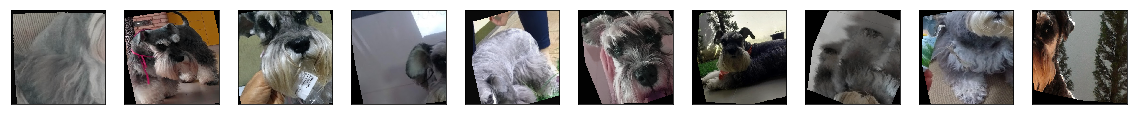

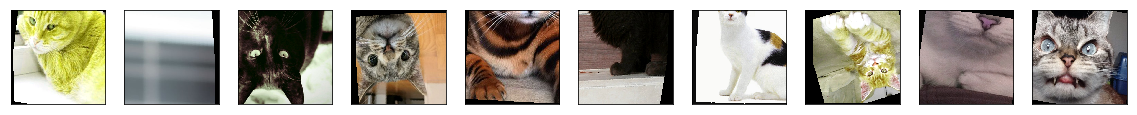

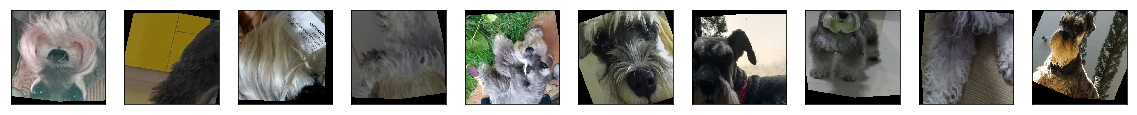

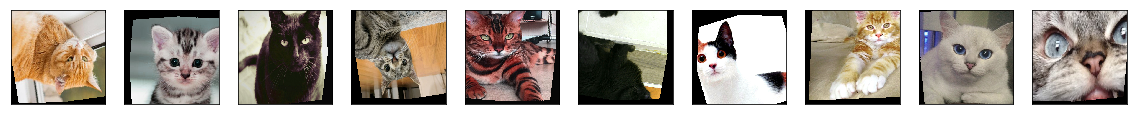

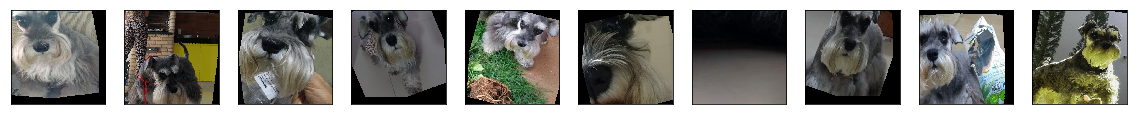

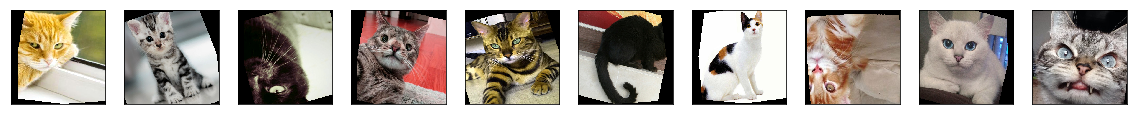

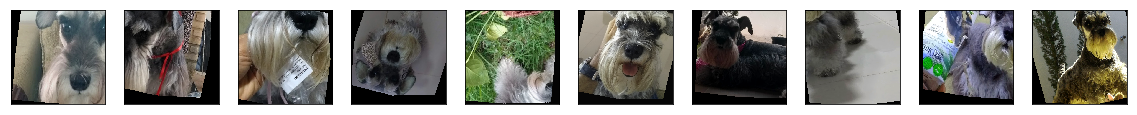

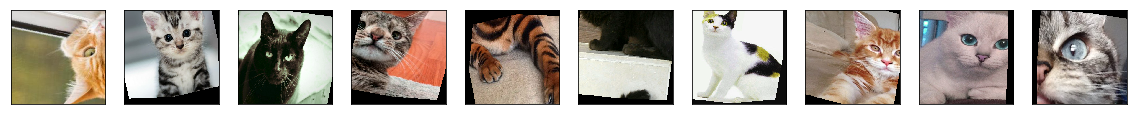

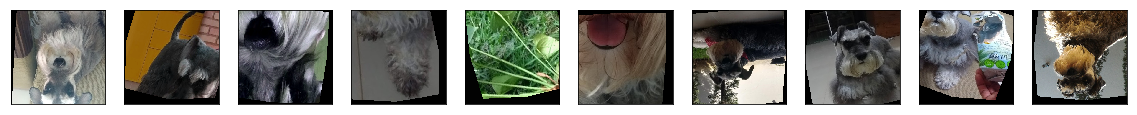

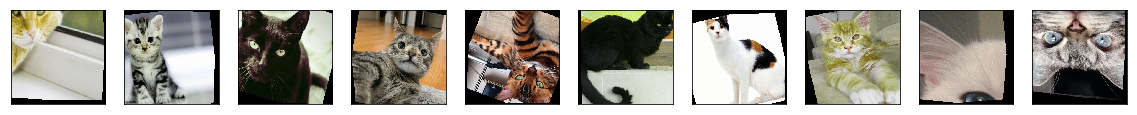

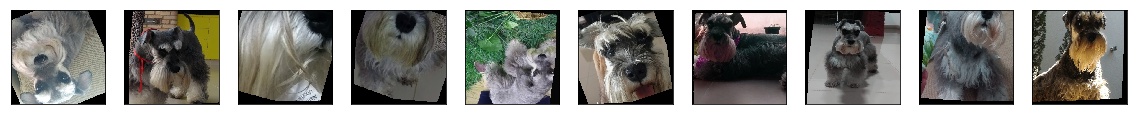

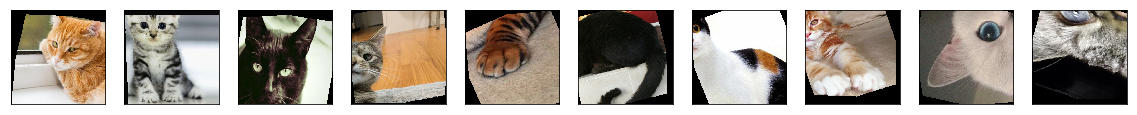

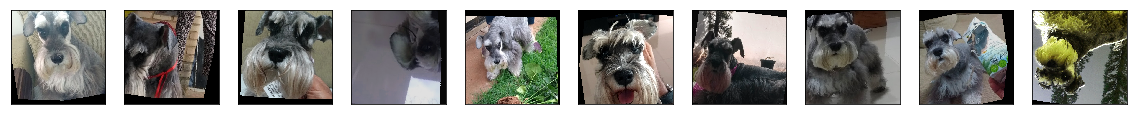

In [7]:
# obtem 10 lotes das imagens aumentadas
for i in range(10):
    
    # obtem um lote das imagens aumentadas
    data, target = next(iter(dataloaders['train'])) 
    show_dataset_batch(data, target)
        